In [1]:
from os.path import join

import matplotlib.pyplot as plt
%matplotlib inline

import gensim
import numpy as np
import scipy as sp

from sklearn.datasets import fetch_20newsgroups


%run ../src/load_data_utils.py
%run ../src/glove_2_word2vec.py

In [2]:
__, DATA_DIR = get_env_vars()
VECTORS_DIR = join(DATA_DIR, 'glove.6B')
VECTORS_FILENAME = 'glove.6B.100d.txt'
VECTORS_FILENAME_DIR = join(VECTORS_DIR, 'glove.6B.100d.txt')

newsgroups_train = fetch_20newsgroups()
newsgroups_test = fetch_20newsgroups(subset='test')

model = gensim.models.KeyedVectors.load(str(join(VECTORS_DIR, 'word2vec.6B.100d')))

## Checking words similarity

$king + woman - man \approx queen$ example

In [3]:
model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.6311717629432678),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

## Preprocessing text

This will make retrieving weights for incorporating tf-idf to aggregated word embeddings easier.

In [4]:
from collections import OrderedDict
import re

TOKENIZING_PATTERN = '(?u)\\b\\w\\w+\\b'

def preprocess_texts(sentences_list):
  return (list(
    map(
      lambda sentence: 
        ' '.join(OrderedDict.fromkeys(re.findall(TOKENIZING_PATTERN, sentence)))
          .lower(),
      sentences_list)))

X_train_text = preprocess_texts(newsgroups_train['data'])
X_test_text = preprocess_texts(newsgroups_test['data'])

## Bag of Words encoding

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(token_pattern=TOKENIZING_PATTERN, min_df=2, max_df=0.025)

X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

X_train.shape

(11314, 55564)

In [6]:
y_train = newsgroups_train['target']
y_test = newsgroups_test['target']

In [7]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_iter=50)
%time X_reduced = tsvd.fit_transform(X_train)

CPU times: user 7.2 s, sys: 12.6 s, total: 19.8 s
Wall time: 5.95 s


## Truncated SVD plot

Truncated SVD of rank $k$ is algorithm that computes $k$ principal components of a matrix, like PCA but iteratively.

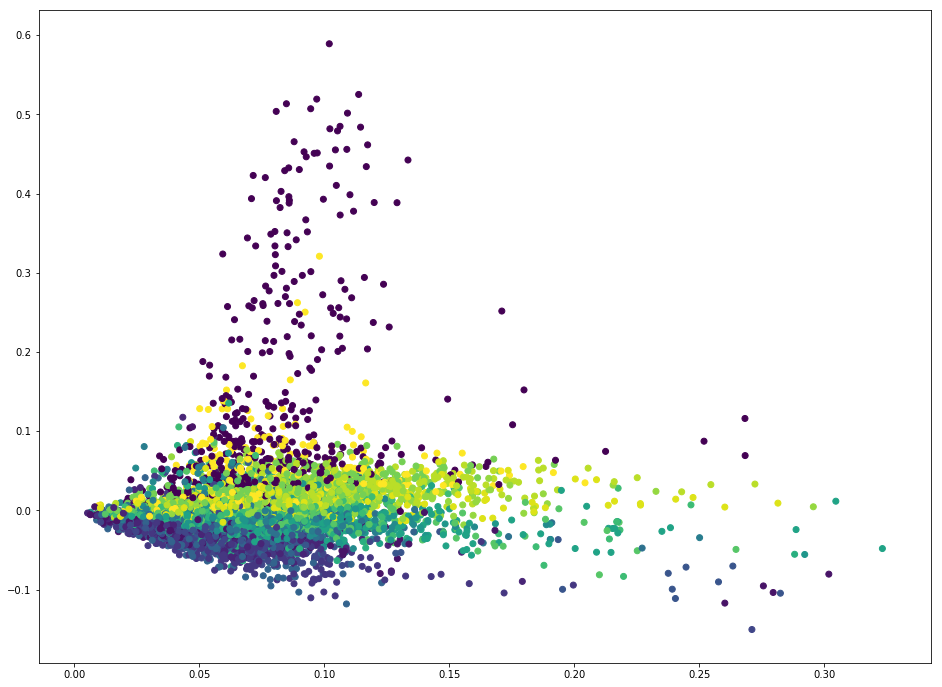

In [8]:
plt.figure(figsize=(16, 12))

plt.scatter(*X_reduced.T, c=y_train)
plt.show()

## Aggregating word embeddings

We'll take two aggregation strategies: the first would be to just average word vectors over the words in a sentence that happen to be in model vocabulary.

The second one also incorporates weights from tf-idf model.

In [9]:
def encode_sentence(w2v_model, sent, weights=None):
  if weights is None:
    normalizing_factor = len(sent)
    word_vectors = (w2v_model[w] for w in sent if w2v_model.vocab.get(w))
  else:
    normalizing_factor = len([w for w in sent if w2v_model.vocab.get(w)])
    word_vectors = (w2v_model[w] * weights[i] for (i, w) in enumerate(sent) if w2v_model.vocab.get(w))
  return sum(word_vectors) / normalizing_factor

In [10]:
%time X_w2v_train = np.array([encode_sentence(model, s.split()) for s in X_train_text])
%time X_w2v_test = np.array([encode_sentence(model, s.split()) for s in X_test_text])

CPU times: user 6.2 s, sys: 12 ms, total: 6.21 s
Wall time: 6.21 s
CPU times: user 4.41 s, sys: 0 ns, total: 4.41 s
Wall time: 4.41 s


In [11]:
from operator import itemgetter
from itertools import groupby

def encode_sentences(X_tfidf, tfidf):
  def get_nonzeros(v):
    try:
      nz = v[v.nonzero()].tolist()
    except AttributeError:
      print(v[v.nonzero()])
    else:
      return v[v.nonzero()].tolist()[0]
  retrieved_sentences = tfidf.inverse_transform(X_tfidf)
  return (np.array(
    [
      encode_sentence(
        model, 
        retrieved_sentences[i],
        weights=get_nonzeros(X_tfidf[i, :]))
      for i in range(X_tfidf.shape[0])]))


In [12]:
%time X_w2v_weighted_train = encode_sentences(X_train, tfidf)
%time X_w2v_weighted_test = encode_sentences(X_test, tfidf)

CPU times: user 16.9 s, sys: 128 ms, total: 17 s
Wall time: 17.1 s
CPU times: user 10.8 s, sys: 8 ms, total: 10.8 s
Wall time: 10.8 s


In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

%time X_w2v_weighted_train_pca = pca.fit_transform(X_w2v_weighted_train)
%time X_w2v_train_pca = pca.fit_transform(X_w2v_train)

CPU times: user 160 ms, sys: 256 ms, total: 416 ms
Wall time: 134 ms
CPU times: user 216 ms, sys: 284 ms, total: 500 ms
Wall time: 140 ms


## Aggregated word embeddings plot

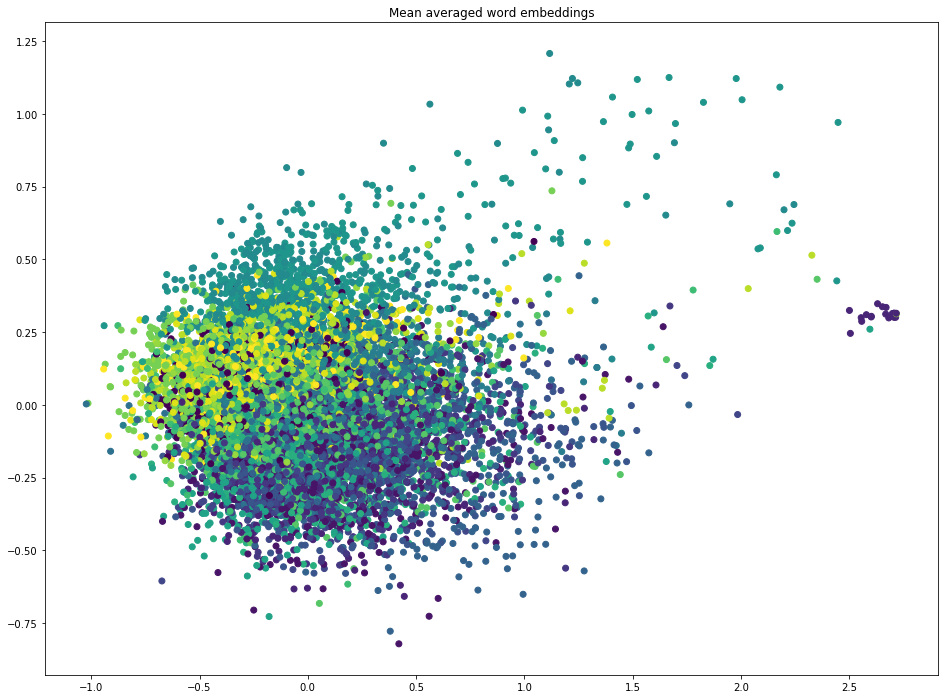

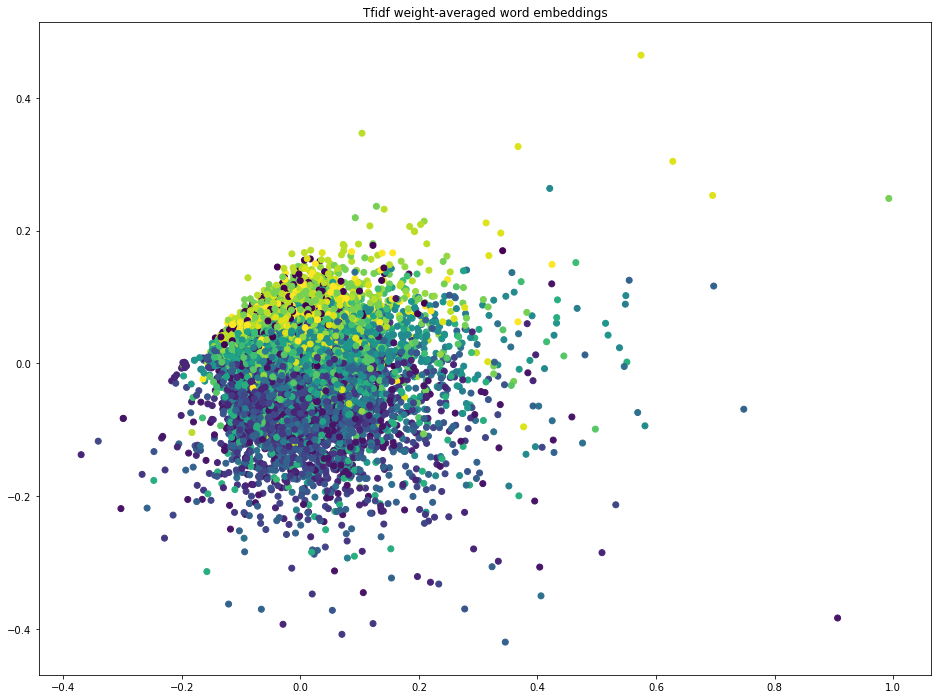

In [14]:
plt.figure(figsize=(16, 12))

plt.title('Mean averaged word embeddings')
plt.scatter(*X_w2v_train_pca.T, c=y_train)
plt.show()

plt.figure(figsize=(16, 12))

plt.title('Tfidf weight-averaged word embeddings')
plt.scatter(*X_w2v_weighted_train_pca.T, c=y_train)
plt.show()

# Classification

We'll use SGDClassifier which uses (linear) SVMs internally.

In [15]:
from sklearn.linear_model import SGDClassifier 

sparse_lreg = SGDClassifier(n_iter=25, alpha=0.0001)

%time sparse_lreg.fit(X_train, y_train)

CPU times: user 2.26 s, sys: 0 ns, total: 2.26 s
Wall time: 2.26 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=25, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

Accuracy on tfidf data

In [16]:
sparse_lreg.score(X_test, y_test)

0.84625597450876267

In [17]:
from sklearn.preprocessing import StandardScaler

dense_lreg = SGDClassifier(n_iter=50, alpha=0.00005)

sscaler = StandardScaler()

X_w2v_normalized_train = sscaler.fit_transform(X_w2v_train)

%time dense_lreg.fit(X_w2v_train, y_train)#, classes=np.unique(y_train))

CPU times: user 3.68 s, sys: 0 ns, total: 3.68 s
Wall time: 3.68 s


SGDClassifier(alpha=5e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

Accuracy on means of embedded words

In [18]:
dense_lreg.score(X_w2v_test, y_test)

0.64524694636218805

In [19]:
dense_lreg = SGDClassifier(n_iter=50, alpha=0.00001)

%time dense_lreg.fit(X_w2v_weighted_train, y_train)#, classes=np.unique(y_train))

CPU times: user 3.68 s, sys: 0 ns, total: 3.68 s
Wall time: 3.68 s


SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

Accuracy on weighted embedded words

In [20]:
dense_lreg.score(X_w2v_weighted_test, y_test)

0.55337227827934143

As we can see, there is radical drop in performance. The next couple of examples can illustrate why.

In [21]:
n = 5
no_closest=5

text_encodings = [X_w2v_train[i, :] for i in range(n)]
text_encodings_weighted = [X_w2v_weighted_train[i, :] for i in range(n)]

Closest $10$ words to mean-aggregated texts

In [22]:
model.most_similar([text_encodings[0]], topn=5)

[('so', 0.9109116792678833),
 ('this', 0.9107068777084351),
 ('one', 0.9097325801849365),
 ('well', 0.9066550731658936),
 ('even', 0.9066197872161865)]

In [23]:
model.most_similar([text_encodings[1]], topn=5)

[('this', 0.8972651958465576),
 ('time', 0.8940219879150391),
 ('only', 0.889031708240509),
 ('same', 0.8874689340591431),
 ('well', 0.8864277601242065)]

In [24]:
model.most_similar([text_encodings[2]], topn=5)

[('so', 0.9269064664840698),
 ('even', 0.9240497350692749),
 ('well', 0.9103280901908875),
 ('it', 0.9094198346138),
 ('this', 0.9068231582641602)]

Closest words to mean-aggregated texts

In [25]:
model.most_similar([text_encodings_weighted[0]], topn=5)

[('today', 0.7099319696426392),
 ('well', 0.7080519199371338),
 ('.', 0.701697587966919),
 ('new', 0.7008072733879089),
 ('few', 0.6982711553573608)]

In [26]:
model.most_similar([text_encodings_weighted[1]], topn=5)

[('time', 0.80085289478302),
 ('this', 0.7895544767379761),
 ('same', 0.7890008091926575),
 ('only', 0.7835026979446411),
 ('one', 0.7550361156463623)]

In [27]:
model.most_similar([text_encodings_weighted[2]], topn=5)

[('just', 0.8935133218765259),
 ('so', 0.8860389590263367),
 ('going', 0.8701095581054688),
 ('even', 0.867659330368042),
 ('only', 0.8574004173278809)]

In [28]:
X_train_text[0], y_train[0], [(w, w in model.vocab) for w in tfidf.inverse_transform(X_train[0, :])[0]]

('from lerxst wam umd edu where my thing subject what car is this nntp posting host rac3 organization university of maryland college park lines 15 was wondering if anyone out there could enlighten me on saw the other day it door sports looked to be from late 60s early 70s called bricklin the doors were really small in addition front bumper separate rest body this all know if can tellme model name engine specs years production made history or whatever info you have funky looking please mail thanks il brought by your neighborhood lerxst',
 7,
 [('60s', True),
  ('70s', True),
  ('addition', True),
  ('bricklin', True),
  ('brought', True),
  ('bumper', True),
  ('door', True),
  ('doors', True),
  ('engine', True),
  ('enlighten', True),
  ('funky', True),
  ('il', True),
  ('late', True),
  ('lerxst', False),
  ('looked', True),
  ('maryland', True),
  ('neighborhood', True),
  ('park', True),
  ('production', True),
  ('rac3', False),
  ('separate', True),
  ('specs', True),
  ('sports